# Remove Anomaly Data by Diff Elbow

The original data is noisy with sudden increase and decrease on request number and transferred data sizes.
This notebook use difference elbow to remove anomalies in request number for further data mining tasks.

## Import Dependencies

In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict

## Some Global Configuration Variables

In [71]:
ROOT="MergedLog"
MERGED_NAME="merged.csv"
OUTPUT="AnomalyRemovedLog"
OUTPUT_NAME="smoothed.csv"

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)

## Read and Plot Merged log

/tmp/ipykernel_119415/2473577911.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  df = df[(df["timestamp"] >= np.datetime64("1998-06-09T00:00:00Z")) & (df["timestamp"] <= np.datetime64("1998-07-13T23:59:59Z"))]


,timestamp,num_request,size
56300,1998-06-09 00:00:00,9521,50856750
56301,1998-06-09 00:01:00,9009,41659434
56302,1998-06-09 00:02:00,9441,45436170
56303,1998-06-09 00:03:00,9636,46345904
56304,1998-06-09 00:04:00,10333,50035640
...,...,...,...
106695,1998-07-13 23:55:00,6756,29948383
106696,1998-07-13 23:56:00,6862,29386925
106697,1998-07-13 23:57:00,6696,38582518
106698,1998-07-13 23:58:00,6524,31089066


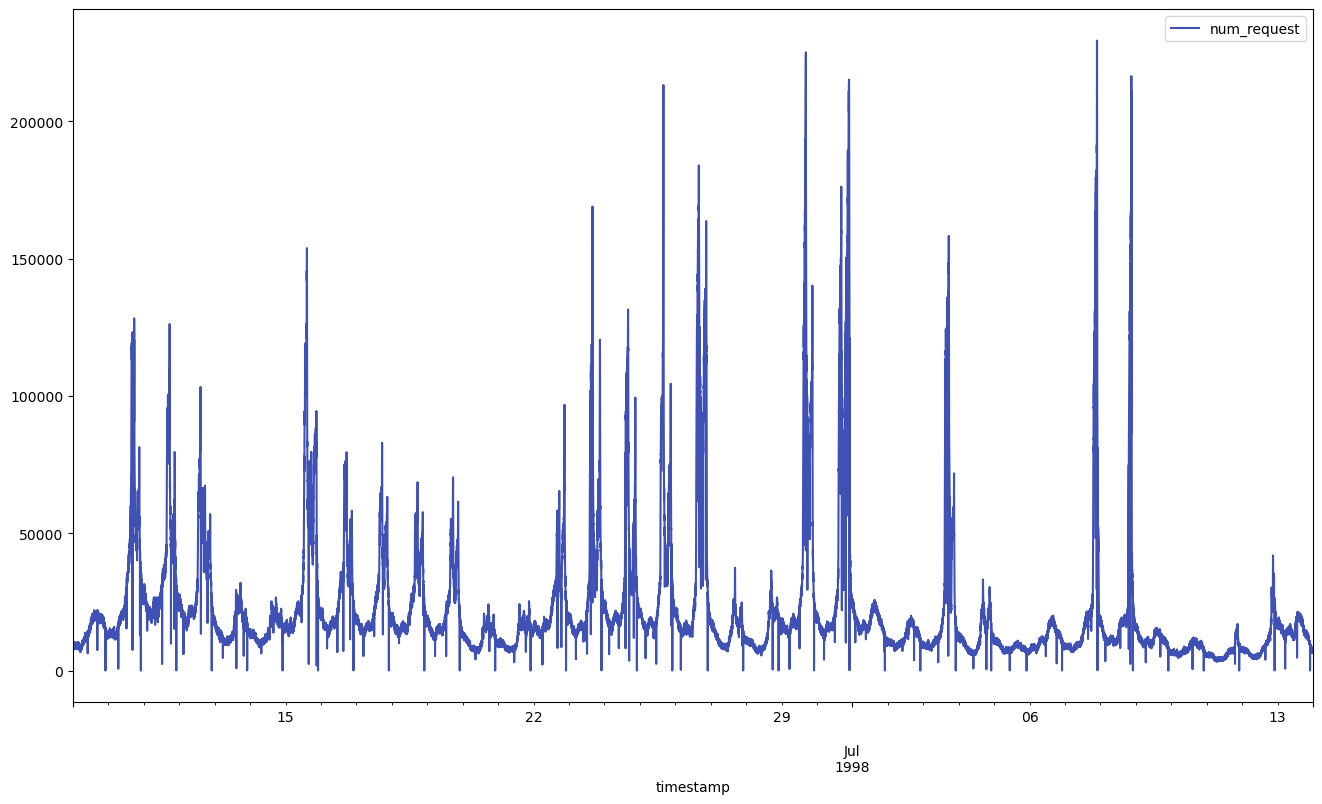

In [72]:
def read_and_plot(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, parse_dates=["timestamp"])
    # filter the time when WorldCup 98 event was held
    df = df[(df["timestamp"] >= np.datetime64("1998-06-09T00:00:00Z")) & (df["timestamp"] <= np.datetime64("1998-07-13T23:59:59Z"))]
    df.plot(x="timestamp", y="num_request", figsize=(16, 9), color="#3F51B5", label="num_request")  # material color indigo
    return df


read_and_plot(os.path.join(ROOT, MERGED_NAME))

## Smooth Anomalies
Find and smooth anomalies by the folling step:
1. Calculate the absolute value of the first order difference of the request number
2. Sort the absolute values in descending order, plot the values
3. Large, anomalous absolute values take a small portion of the whole absolute value set. The figure will have an obvious "elbow"
4. Take the elbow value as criteria, remove the sudden peaks and valleys in the figure of the original request number

### Calculate abs(difference)

/tmp/ipykernel_119415/2473577911.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  df = df[(df["timestamp"] >= np.datetime64("1998-06-09T00:00:00Z")) & (df["timestamp"] <= np.datetime64("1998-07-13T23:59:59Z"))]


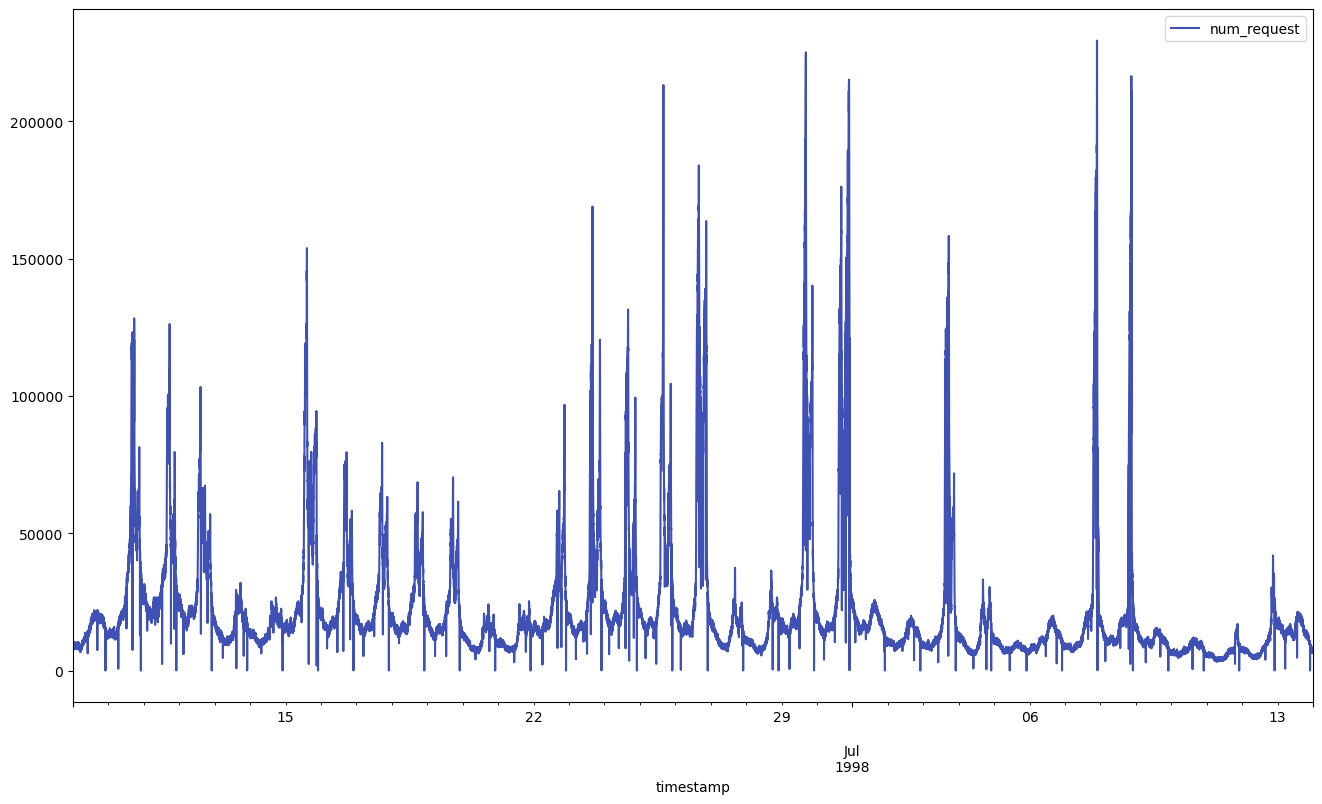

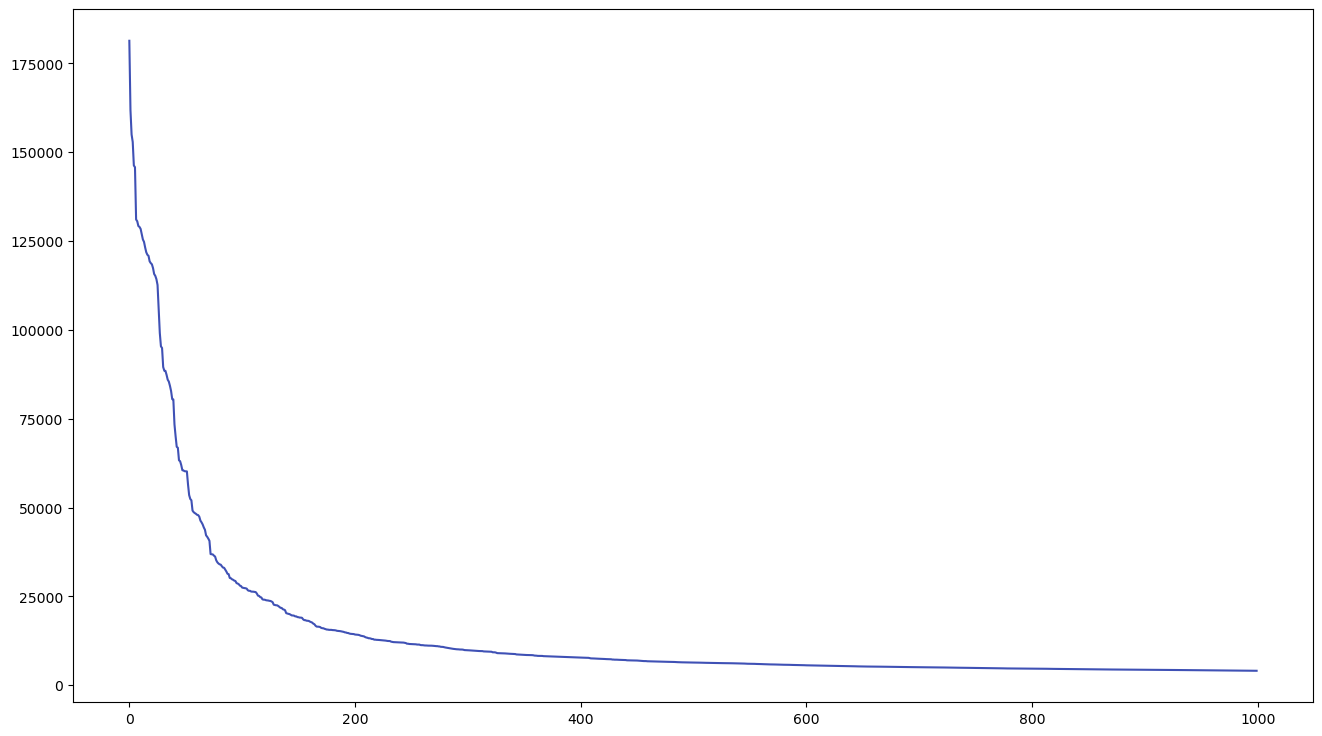

In [73]:
def get_difference(series: np.ndarray) -> Dict:
    diff_dict = {}
    diff_ndarray = np.abs(np.diff(series))
    # each idx is associated with a difference value
    for idx in range(len(diff_ndarray)):
        diff_dict[idx] = diff_ndarray[idx]
    # sort the dict
    diff_dict = dict(sorted(diff_dict.items(), key=lambda x: x[1], reverse=True))
    return diff_dict


def plot_difference(diff_dict: Dict):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 9)
    ax.plot(range(len(diff_dict))[:1000], list(diff_dict.values())[:1000], color="#3F51B5")


plot_difference(get_difference(read_and_plot(os.path.join(ROOT, MERGED_NAME))["num_request"].to_numpy()))

### Smooth sudden peaks and valleys

The anomalous threshold (elbow) is about 5000 from the above figure.

/tmp/ipykernel_119415/2473577911.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  df = df[(df["timestamp"] >= np.datetime64("1998-06-09T00:00:00Z")) & (df["timestamp"] <= np.datetime64("1998-07-13T23:59:59Z"))]
/tmp/ipykernel_119415/2473577911.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  df = df[(df["timestamp"] >= np.datetime64("1998-06-09T00:00:00Z")) & (df["timestamp"] <= np.datetime64("1998-07-13T23:59:59Z"))]


Smooth abnormal value from position 598 to 598,new value 12752
Smooth abnormal value from position 990 to 990,new value 20581
Smooth abnormal value from position 1320 to 1320,new value 14395
Smooth abnormal value from position 1842 to 1842,new value 16268
Smooth abnormal value from position 2174 to 2174,new value 29669
Smooth abnormal value from position 2346 to 2346,new value 54838
Smooth abnormal value from position 2375 to 2375,new value 97937
Smooth abnormal value from position 2421 to 2422,new value 119058
Smooth abnormal value from position 2422 to 2422,new value 118494
Smooth abnormal value from position 2485 to 2486,new value 120452
Smooth abnormal value from position 2486 to 2486,new value 123956
Smooth abnormal value from position 2491 to 2494,new value 107984
Smooth abnormal value from position 2492 to 2494,new value 99357
Smooth abnormal value from position 2493 to 2494,new value 95043
Smooth abnormal value from position 2494 to 2494,new value 92886
Smooth abnormal value fr

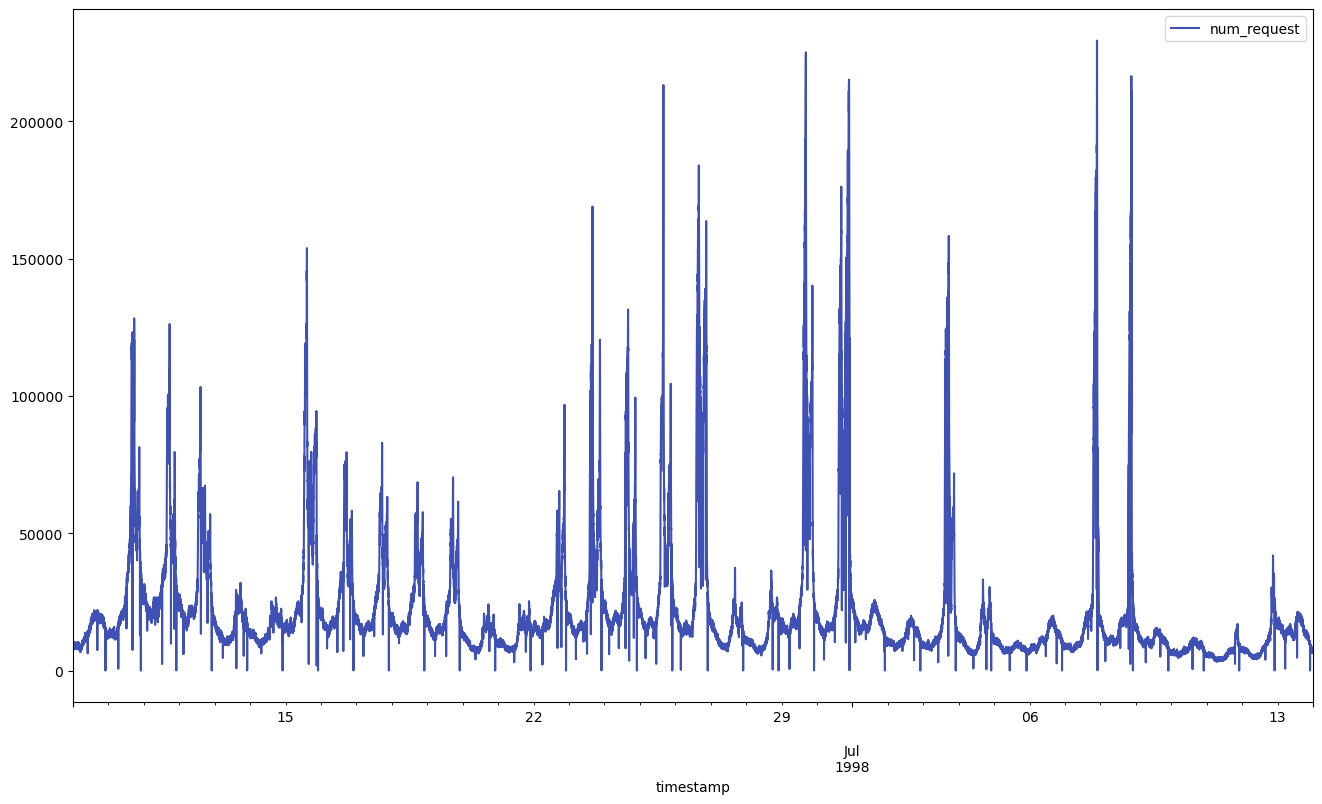

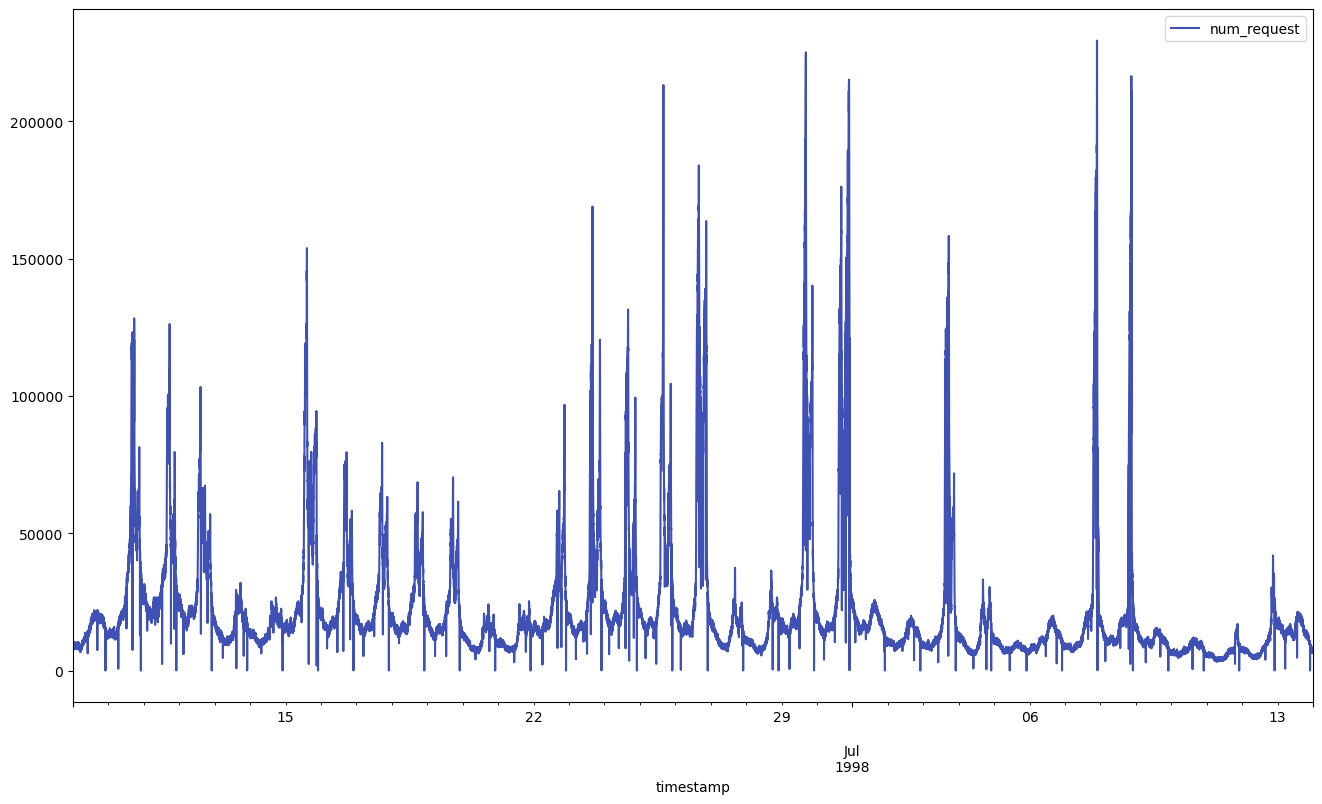

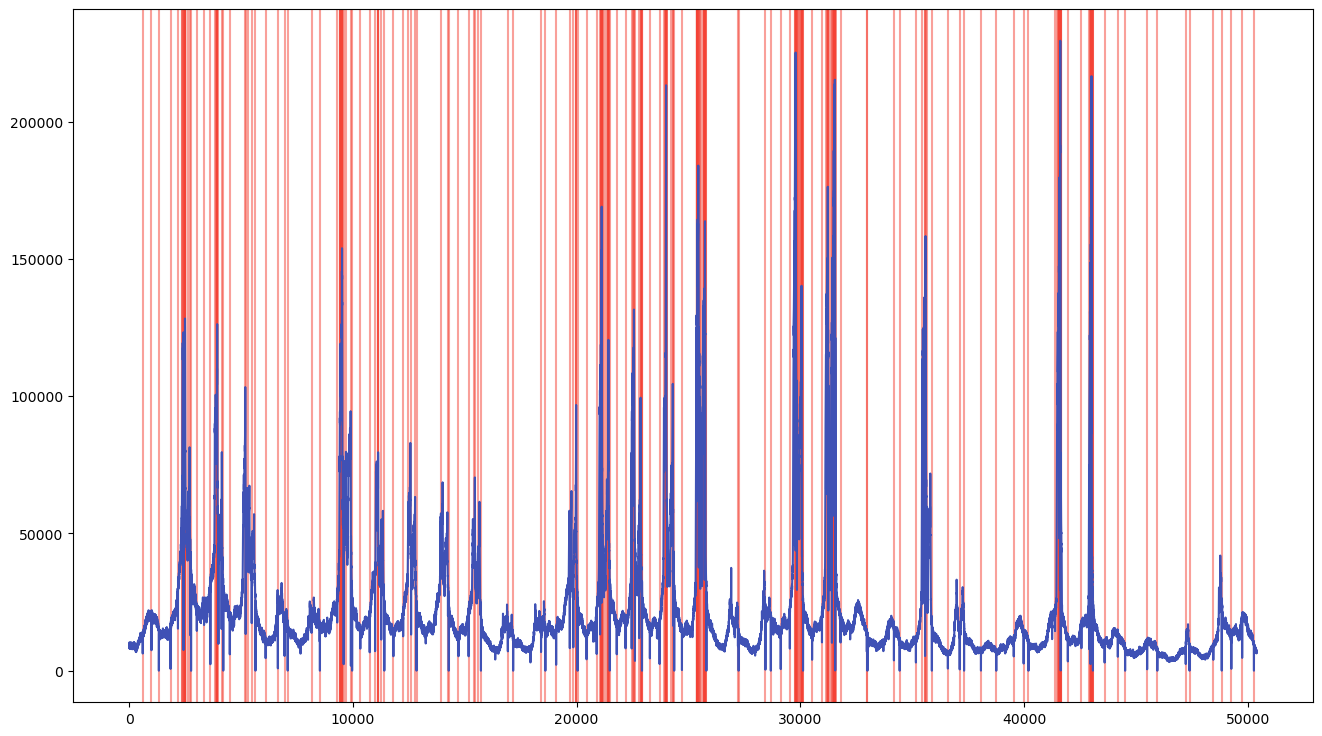

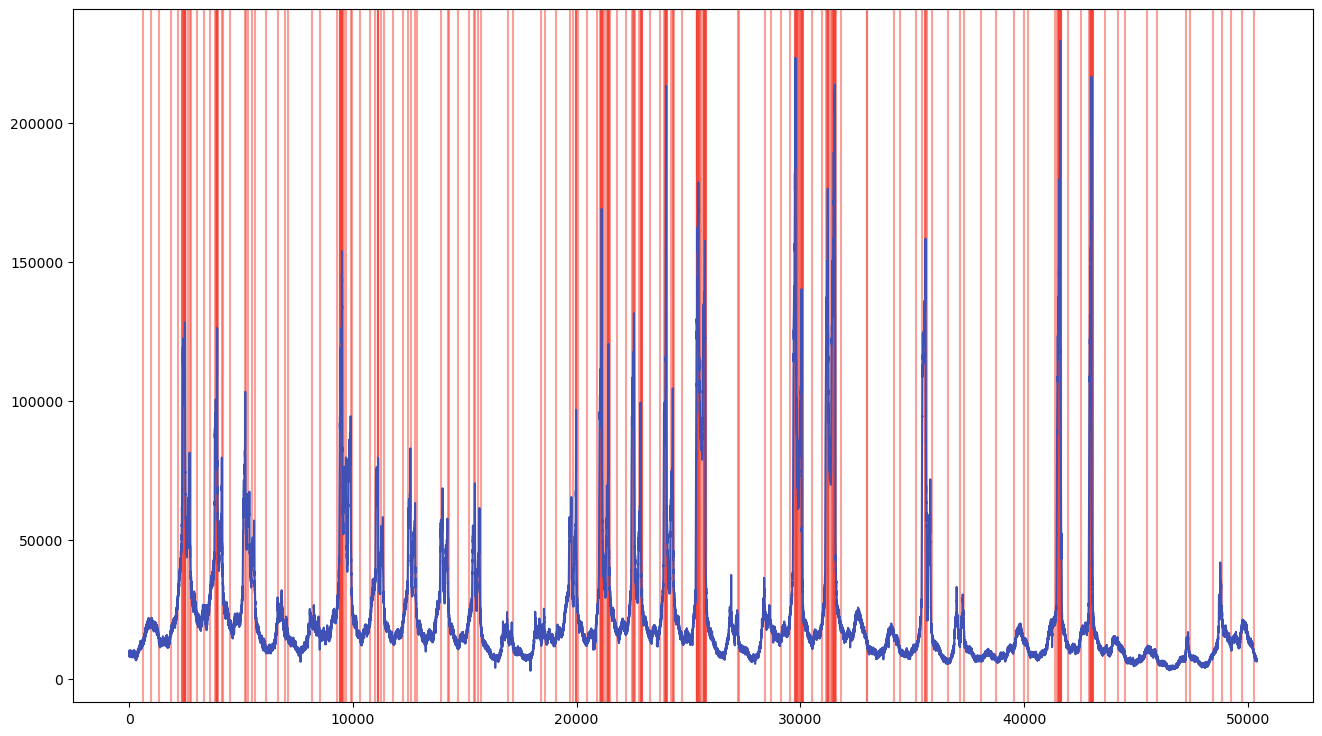

array([9521, 9009, 9441, ..., 6696, 6524, 6974])

In [74]:
def smooth_peak_and_valley(series: np.ndarray, diff_dict: Dict, threshold: float) -> np.ndarray:
    abnormal_indexes = np.array([])
    series_smoothed = series.copy()
    num_corrected = 0
    # following code find sudden peaks and valleys (shape like V or ^) in dataset
    for i in range(len(series)-1):
        if diff_dict[i] > threshold:
            j = i+1
            while diff_dict[j] > threshold:
                j += 1
            if j > i+1:
                # replace abnormal value by mean
                new_value = np.ceil(np.mean([series_smoothed[i], series_smoothed[j]]))
                print("Smooth abnormal value from position %d to %d,new value %d" % (i+1, j-1, new_value))
                series_smoothed[i+1:j] = new_value
                num_corrected += j-i-1
                abnormal_indexes = np.hstack((abnormal_indexes, [k for k in range(i+1, j)]))
                i = j
    print("%d corrected" % num_corrected)

    # plot original series
    xrange = np.arange(len(series))
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 9)
    ax.plot(xrange, series, color="#3F51B5", zorder=2)
    for idx in abnormal_indexes:
        ax.axvline(x=idx, color="#F44336", alpha=0.5, zorder=1)
    plt.show()

    # plot smoothed anomalies
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 9)
    ax.plot(xrange, series_smoothed, color='#3F51B5', zorder=2)
    for idx in abnormal_indexes:
        ax.axvline(x=idx, color='#F44336', alpha=0.5, zorder=1)
    plt.show()

    return series_smoothed


smooth_peak_and_valley(read_and_plot(os.path.join(ROOT, MERGED_NAME))["num_request"].to_numpy(), get_difference(read_and_plot(os.path.join(ROOT, MERGED_NAME))["num_request"].to_numpy()), 5000.0)

## Put it together



/tmp/ipykernel_119415/2473577911.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  df = df[(df["timestamp"] >= np.datetime64("1998-06-09T00:00:00Z")) & (df["timestamp"] <= np.datetime64("1998-07-13T23:59:59Z"))]


Smooth abnormal value from position 598 to 598,new value 12752
Smooth abnormal value from position 990 to 990,new value 20581
Smooth abnormal value from position 1320 to 1320,new value 14395
Smooth abnormal value from position 1842 to 1842,new value 16268
Smooth abnormal value from position 2174 to 2174,new value 29669
Smooth abnormal value from position 2346 to 2346,new value 54838
Smooth abnormal value from position 2375 to 2375,new value 97937
Smooth abnormal value from position 2421 to 2422,new value 119058
Smooth abnormal value from position 2422 to 2422,new value 118494
Smooth abnormal value from position 2485 to 2486,new value 120452
Smooth abnormal value from position 2486 to 2486,new value 123956
Smooth abnormal value from position 2491 to 2494,new value 107984
Smooth abnormal value from position 2492 to 2494,new value 99357
Smooth abnormal value from position 2493 to 2494,new value 95043
Smooth abnormal value from position 2494 to 2494,new value 92886
Smooth abnormal value fr

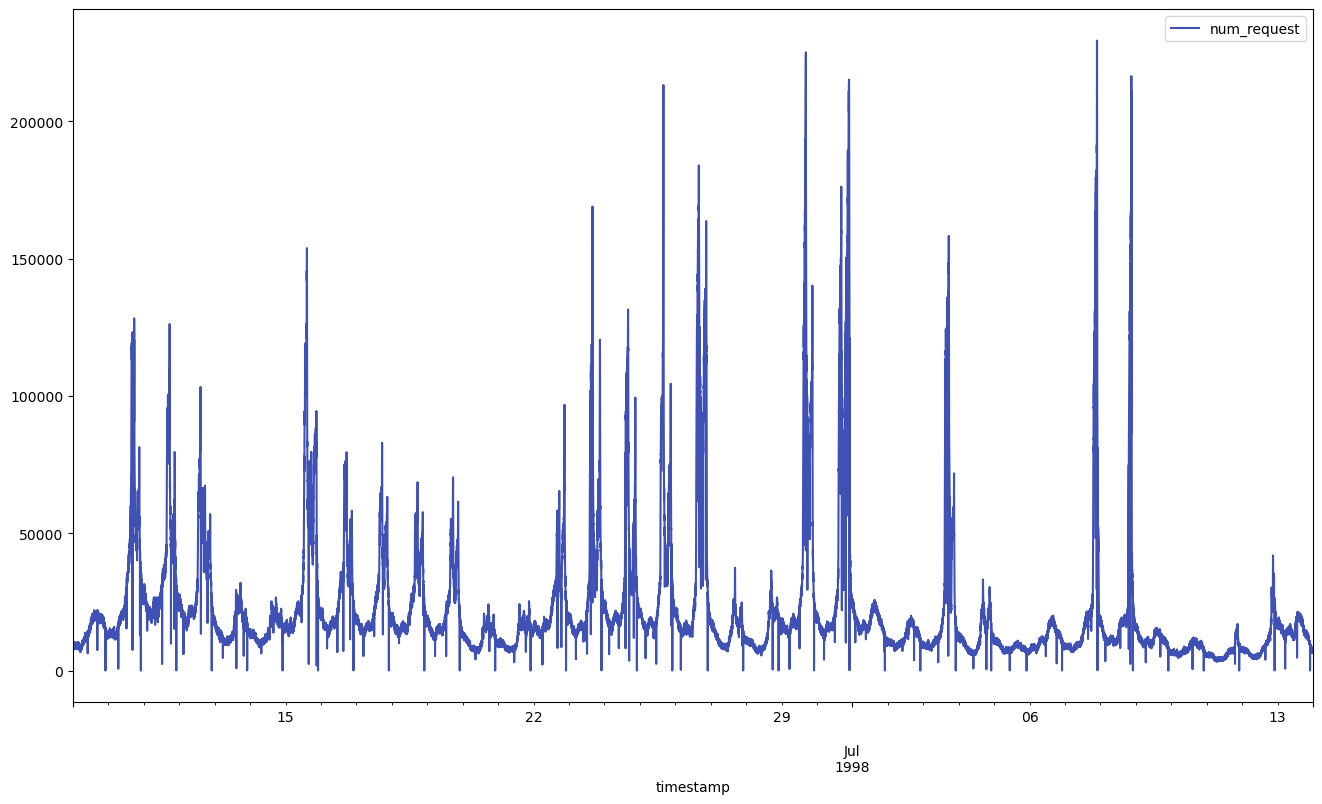

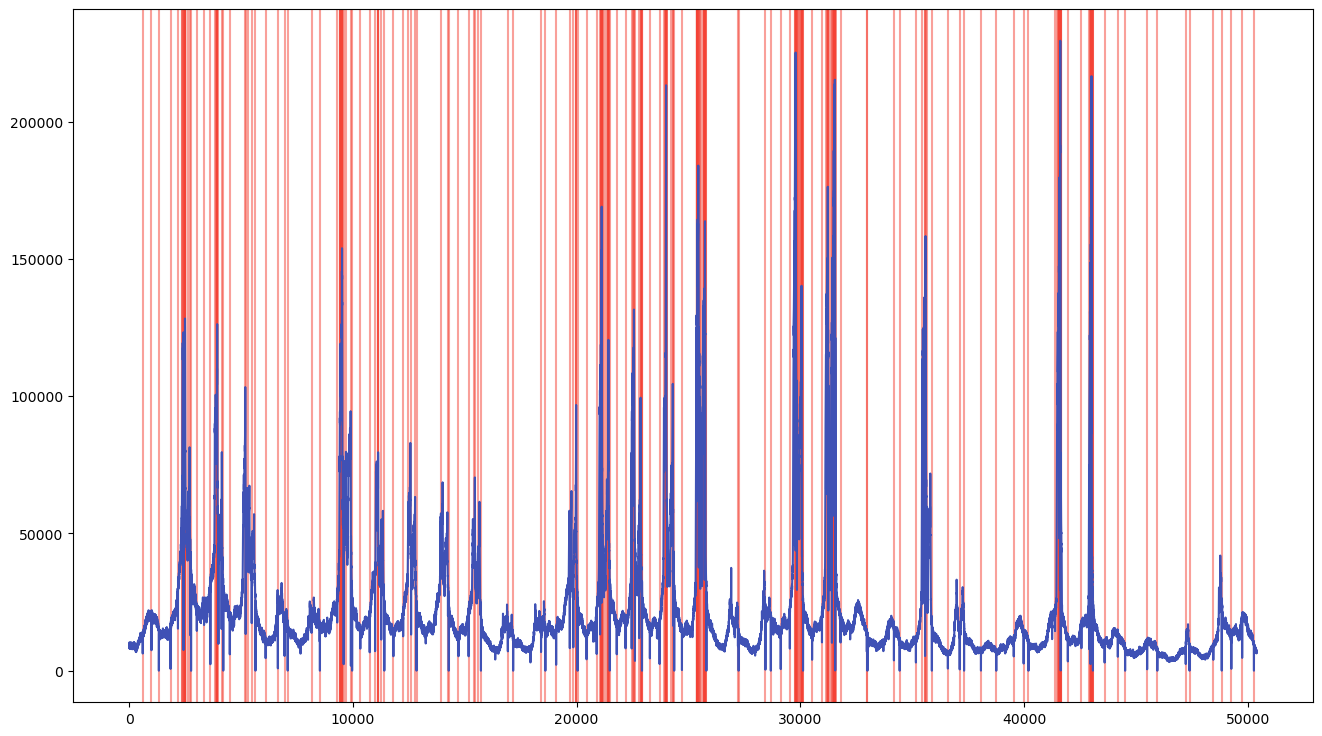

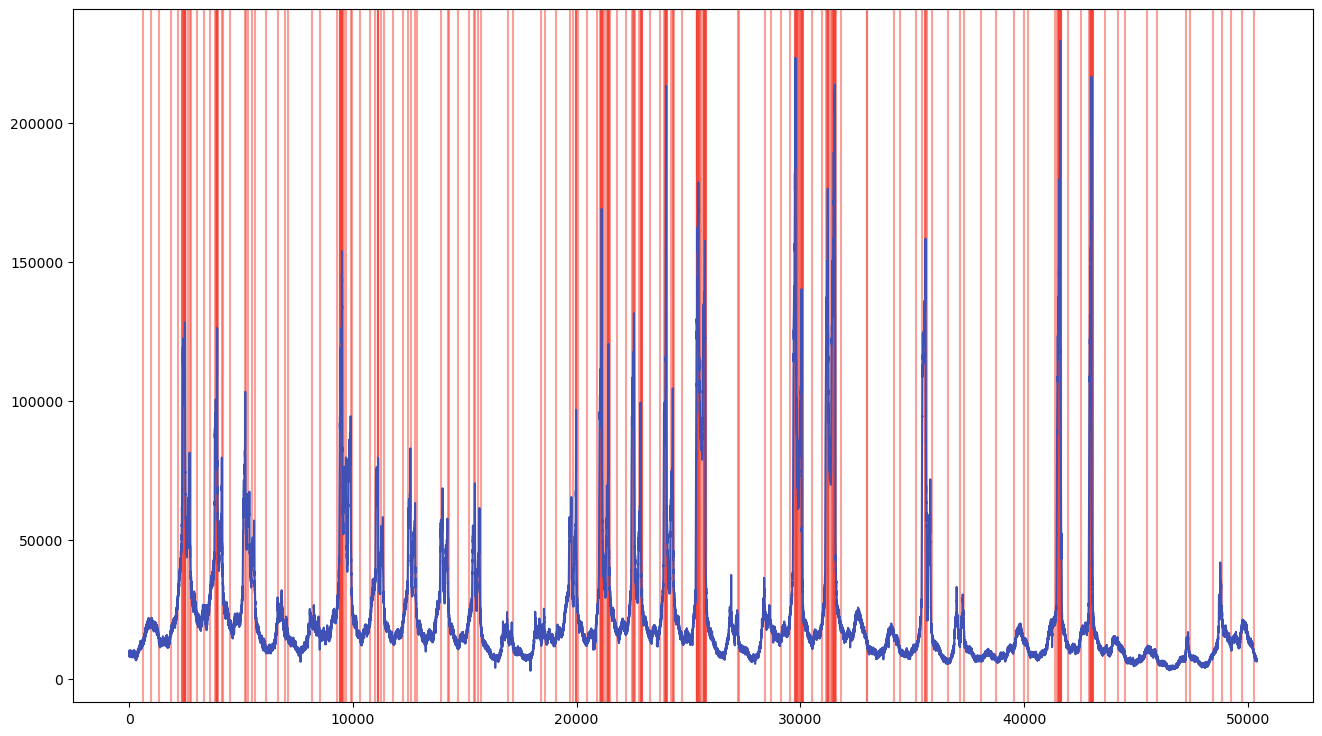

In [75]:
if __name__=="__main__":
    df=read_and_plot(os.path.join(ROOT, MERGED_NAME))
    num_requests=df["num_request"].to_numpy()
    diff_dict=get_difference(num_requests)
    num_requests_smoothed=smooth_peak_and_valley(num_requests,diff_dict,5000)
    df["num_request"]=num_requests_smoothed
    df.to_csv(os.path.join(OUTPUT,OUTPUT_NAME),index=False)